In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from neo4j import GraphDatabase

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "test1234"), encrypted=False)

In [3]:
# Create projection 
with driver.session(database = "paysim") as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
        """CALL gds.graph.create(
            'payment', 
            { Client: { label: 'Client', properties: { class: { property: 'class'} } } }, 
            { PAYS: { type: 'PAYS', orientation:'UNDIRECTED'} }, 
            {
                nodeProperties: { },
                relationshipProperties: {amount: { property: 'amount', aggregation: 'NONE', defaultValue: 0.0 }}
            }
        )"""
    ).single()
    )
    print(result)

<Record nodeProjection={'Client': {'properties': {'class': {'property': 'class', 'defaultValue': None}}, 'label': 'Client'}} relationshipProjection={'PAYS': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'PAYS', 'properties': {'amount': {'property': 'amount', 'aggregation': 'NONE', 'defaultValue': 0.0}}}} graphName='payment' nodeCount=21910 relationshipCount=388602 createMillis=162>


In [4]:
# Run FastRP embedding
with driver.session(database = "paysim") as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """CALL gds.fastRP.mutate(
            'payment', 
            {
                embeddingDimension: 8,
                iterationWeights: [0.0, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00],
                relationshipWeightProperty: 'amount',
                mutateProperty:'fastRP'
            }
            )"""
        ).single()
    )
    print(result)

<Record nodePropertiesWritten=21910 mutateMillis=0 nodeCount=21910 createMillis=0 computeMillis=76 configuration={'normalizationStrength': 0.0, 'iterationWeights': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'embeddingDimension': 8, 'relationshipWeightProperty': 'amount', 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'mutateProperty': 'fastRP', 'concurrency': 4}>


In [5]:
# Stream back embeddings for 2d vis
embedding = []
category = []
with driver.session(database = "paysim") as session:
    data = session.read_transaction( lambda tx: 
        tx.run(
            """CALL gds.graph.streamNodeProperties(
            'payment', 
            ['class','fastRP'],
            ['Client']
            ) YIELD nodeId, nodeProperty, propertyValue 
            return * limit 1000"""
        ).data()
    )
    for record in data:
        if record['nodeProperty'] == 'fastRP':
            embedding.append(record["propertyValue"])
        if record['nodeProperty'] == 'class':
            category.append(record["propertyValue"])


In [6]:
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.910370
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.484482
[t-SNE] KL divergence after 1000 iterations: 1.486242


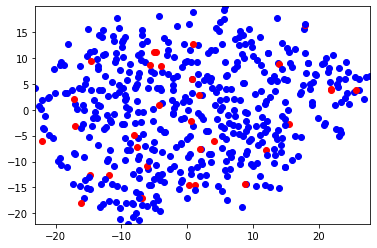

In [7]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot


for label, x, y in zip(category, x_coords, y_coords):
    if label == 0:
        plt.scatter(x, y, color='blue')
    else:
        plt.scatter(x, y, color='red')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()


In [8]:
# Train Node Classification ML
with driver.session(database = "paysim") as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
        """CALL gds.alpha.ml.nodeClassification.train('payment', {
            nodeLabels: ['Client'],
            modelName: 'fraud-model',
            featureProperties: ['fastRP'],
            targetProperty: 'class',
            randomSeed: 2,
            holdoutFraction: 0.3,
            validationFolds: 5,
            metrics: [ 'ACCURACY' ],
            params: [
                {penalty: 0.0625},
                {penalty: 0.5},
                {penalty: 1.0},
                {penalty: 4.0}
                ]
            }
            )"""
        ).single()['modelInfo']
    )
    print(result)

{'name': 'fraud-model', 'metrics': {'ACCURACY': {'outerTrain': 0.91236307, 'test': 0.91420749, 'validation': [{'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 0.0625}, 'max': 0.9126182}, {'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 0.5}, 'max': 0.9126182}, {'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 1.0}, 'max': 0.9126182}, {'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 4.0}, 'max': 0.9126182}], 'train': [{'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 0.0625}, 'max': 0.9123808}, {'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 0.5}, 'max': 0.9123808}, {'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 1.0}, 'max': 0.9123808}, {'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 4.0}, 'max': 0.9123808}]}}, 'type': 'multiClassNodeLogisticRegression', 'bestParameters': {'penalty': 0.0625}, 'classes': [0, 1]}


In [9]:
# Drop projection
with driver.session(database = "paysim") as session:
    result = session.read_transaction(lambda tx: 
        tx.run("CALL gds.graph.drop('payment')").single()
    )
    print(result)

<Record graphName='payment' database='paysim' memoryUsage='294 MiB' sizeInBytes=308779160 detailSizeInBytes={'relationships': {'total': 5948352, 'everything': 5948688, 'offsets': 180712, 'adjacencyList': 5767640}, 'total': 308779160, 'nodes': {'sparseLongArray': 446880, 'forwardMapping': 0, 'backwardMapping': 0, 'total': 446880, 'everything': 449880}} nodeProjection={'Client': {'properties': {'class': {'property': 'class', 'defaultValue': None}}, 'label': 'Client'}} relationshipProjection={'PAYS': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'PAYS', 'properties': {'amount': {'property': 'amount', 'aggregation': 'NONE', 'defaultValue': 0.0}}}} nodeQuery=None relationshipQuery=None nodeCount=21910 relationshipCount=388602 density=0.0008095433292920955 creationTime=neo4j.time.DateTime(2021, 3, 23, 13, 29, 54.507635, tzinfo=<DstTzInfo 'Europe/Stockholm' CET+1:00:00 STD>) modificationTime=neo4j.time.DateTime(2021, 3, 23, 13, 29, 54.760163, tzinfo=<DstTzInfo 'Europe/Stockh

In [10]:
# Drop Node Classification Model
with driver.session(database = "paysim") as session:
    result = session.read_transaction(lambda tx: 
        tx.run("CALL gds.beta.model.drop('fraud-model')").single()
    )
    print(result)

<Record modelInfo={'modelName': 'fraud-model', 'modelType': 'multiClassNodeLogisticRegression', 'metrics': {'ACCURACY': {'outerTrain': 0.91236307, 'test': 0.91420749, 'validation': [{'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 0.0625}, 'max': 0.9126182}, {'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 0.5}, 'max': 0.9126182}, {'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 1.0}, 'max': 0.9126182}, {'avg': 0.9123630779999999, 'min': 0.91229215, 'params': {'penalty': 4.0}, 'max': 0.9126182}], 'train': [{'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 0.0625}, 'max': 0.9123808}, {'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 0.5}, 'max': 0.9123808}, {'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 1.0}, 'max': 0.9123808}, {'avg': 0.9123630720000001, 'min': 0.9122993, 'params': {'penalty': 4.0}, 'max': 0.9123808}]}}, 'bestParameters': {'penalty': 0.0625}, 'classes': 